## Load necessary python modules

In [1]:
import os
import napari
import numpy as np
import pandas as pd
import trackpy as tp
import matplotlib.pyplot as plt

import bigfish
import bigfish.plot as plot
import bigfish.stack as stack
import bigfish.detection as detection
import bigfish.multistack as multistack

from copy import deepcopy
from get3DBlurredSequence import *
from dask.array.image import imread as imr
from bigfish.detection.utils import get_object_radius_pixel
from buildReferenceSpot import buildReferenceSpotFromImages
from runBigfishDetection import getSpotAndClusters, saveSpotsNPZ

pd.set_option('display.max_rows', 1500)

## Specify Input and Output folders, identifiers

In [2]:
homeFolder = '../demoData/'
nameKey = 'Hela_h9_h2_k11_mcpsg_1hrbasal_14hr_10ng.ml_tnf_exp1_4_F'

imsQ = '11'
cellNumber = '2'
nucleiStackForm = nameKey+imsQ+"_cell_"

pathToTimeSequenceFullView = homeFolder+nameKey+imsQ+'/*.tif'
cell_Crop_Folder = homeFolder+nameKey+imsQ+'/cell_'+str(cellNumber)+'/'
pathToTimeSequenceCell = homeFolder+nameKey+imsQ+'/cell_'+str(cellNumber)+'/*.tif'


sequenceCell = imr(pathToTimeSequenceCell)
mipSequenceCell = np.max(sequenceCell, axis=1)
MaxTimePoint = sequenceCell.shape[0]

## Load detection and Clustering Results

In [3]:

spcl = np.load(cell_Crop_Folder+str(cellNumber)+'_spots_and_clusters.npz',allow_pickle=True)

spotsFrame = spcl['spotsFrame']
clustersFrames = spcl['clustersFrames']
ThresholdFrames = spcl['ThresholdFrames']
reference_spot = spcl['reference_spot']
refSpot = deepcopy(reference_spot)

## Make 2D reference spot adjusted for use with computatutional 3D blurr of image sequence 

1999.3500000000001


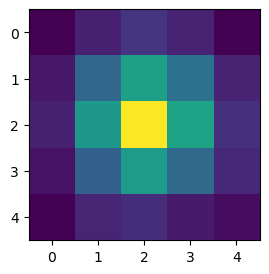

In [4]:
refSpot2D = np.max(reference_spot, axis=0)*0.45
plt.figure(num=3,figsize=(3,3))
plt.imshow(refSpot2D)
print(np.max(refSpot2D))

## Obtain 3D blurred image sequence

In [5]:
blurImage = get3DBlurredSequence(sequenceCell, 9)

viewer = napari.Viewer()
image_layer = viewer.add_image(
        blurImage, colormap='green'
        )

## Perform detection on blurred image to get high confidence tracks

In [7]:
bETA = 2.2
gAMMA = 5
thresholdManual = 1700
clusterRadius = 400
clusterSpotsMinimum = 5


voxelRadius2D = (121, 121)
objectRadius2D = (105, 105)
xPos = np.array([])
yPos = np.array([])
blurClusters = []
visualiseSpots = False

for t in range(0,len(blurImage)):

    rna = blurImage[t]

    # spot radius
    spot_radius_px = detection.get_object_radius_pixel(
        voxel_size_nm=voxelRadius2D,#(600, 80, 80), 
        object_radius_nm=objectRadius2D, 
        ndim=2)

    # LoG filter
    rna_log = stack.log_filter(rna, sigma=spot_radius_px)

    # local maximum detection
    mask = detection.local_maximum_detection(rna_log, min_distance=spot_radius_px)

    # thresholding
    threshold = detection.automated_threshold_setting(rna_log, mask)

    spots_current, _ = detection.spots_thresholding(rna_log, mask,thresholdManual)


    # gaussian kernel
    kernel_size = detection.get_object_radius_pixel(
        voxel_size_nm=voxelRadius2D, 
        object_radius_nm=objectRadius2D, 
        ndim=2)
    large_kernel_size = tuple([kernel_size_ * gAMMA for kernel_size_ in kernel_size])

    # denoising
    rna_denoised = stack.remove_background_gaussian(rna, sigma=large_kernel_size)

    # reference spot
    reference_spot = deepcopy(refSpot)

    # fit a gaussian function on the reference spot
    sigma_yx, amplitude, background = detection.modelize_spot(
        reference_spot=refSpot2D, 
        voxel_size=voxelRadius2D, 
        spot_radius=objectRadius2D)

    # detect dense regions
    regions_to_decompose, spots_out_regions, region_size = detection.get_dense_region_live(
        image=rna, 
        spots=spots_current,
        voxel_size=voxelRadius2D,
        spot_radius=objectRadius2D,
        reference_spot=refSpot2D,
        beta=bETA)

    print('time='+str(t))
    clusters = []
    ndim=2
    stack.check_array(
        rna,
        ndim=[2, 3],
        dtype=[np.uint8, np.uint16, np.float32, np.float64])
    # case where no region where detected
    if regions_to_decompose.size == 0:
        dense_regions = np.array([], dtype=rna.dtype).reshape((0, ndim + 4))
        blurClusters.append(np.array([],dtype=np.int64).reshape((0, 2)))
    #    return spots, dense_regions, reference_spot
    else :
        # precompute gaussian function values
        max_grid = max(200, region_size + 1)
        precomputed_gaussian = detection.precompute_erf(
            ndim=2,
            voxel_size=voxelRadius2D,
            sigma=(sigma_yx, sigma_yx),
            max_grid=max_grid)

        # simulate gaussian mixtures
        spots_in_regions, _ = detection.simulate_gaussian_mixture(
            image=rna,
            candidate_regions=regions_to_decompose,
            voxel_size=voxelRadius2D,
            sigma=(sigma_yx, sigma_yx),
            amplitude=amplitude,
            background=background,
            precomputed_gaussian=precomputed_gaussian)

        spots_post_decomposition = np.concatenate((spots_out_regions, spots_in_regions[:, :2]), axis=0)

        if visualiseSpots==True:        
            plot.plot_detection(rna, 
                                    spots=[spots_current, spots_in_regions[:, :2]], 
                                    shape=["circle", "polygon"], 
                                    radius=[3, 6], 
                                    color=["red", "yellow"],
                                    linewidth=[1, 2], 
                                    fill=[False, False], 
                                    contrast=True)

        spots_post_clustering, clusters = detection.detect_clusters(
            spots=spots_post_decomposition, 
            voxel_size=voxelRadius2D, 
            radius=clusterRadius, 
            nb_min_spots=clusterSpotsMinimum)

        xPos = np.hstack([xPos,clusters[:,0]])
        yPos = np.hstack([yPos,clusters[:,1]])

        blurClusters.append(clusters[:,0:2])
        if visualiseSpots==True:
            plot.plot_detection(rna, 
                                spots=[spots_current, clusters[:,:2]], 
                                shape=["circle", "polygon"], 
                                radius=[3, 6], 
                                color=["red", "blue"],
                                linewidth=[1, 2], 
                                fill=[False, False], 
                                contrast=True)


time=0
time=1
time=2
time=3
time=4
time=5
time=6
time=7
time=8
time=9
time=10
time=11


## Visualise detection results

In [8]:
def getDetectedClustersForFrameBlur(pts_coordinates, frameNumer):
    sd = np.shape(pts_coordinates[frameNumer][:])
    pts_coords = np.empty([sd[0],sd[1]])
    for ii in range(np.shape(pts_coordinates[frameNumer][:])[0]):
        pts_coords[ii,:] = pts_coordinates[frameNumer][ii][:]
    return pts_coords

def set_pts_features(cls_layer, cluster_coordinate, step): #TxLayer
    # step is a 4D coordinate with the current slider position for each dim
    frameNumber = step[0]  # grab the leading ("time") coordinate
    cls_layer.data = getDetectedClustersForFrameBlur(cluster_coordinate,frameNumber)


cluster_coordinate_blur = blurClusters
viewer = napari.Viewer()
image_layer = viewer.add_image(
        blurImage, colormap='green' #maxImageCell
        )

bigfish_clusters_blur = viewer.add_points(
        getDetectedClustersForFrameBlur(cluster_coordinate_blur,int(np.shape(blurImage)[0]/2)),
        face_color='#00000000',
        size=8,
        edge_width=0.3,
        edge_width_is_relative=False,
        edge_color='red',
        face_color_cycle = ['red'],
        symbol='diamond',
        name = 'bigFish Clusters'
        )

viewer.dims.events.current_step.connect(
        lambda event: set_pts_features(bigfish_clusters_blur, cluster_coordinate_blur, event.value)
        )

<function __main__.<lambda>(event)>

## Linking of trajectories

In [17]:
MaxTimePoint = len(blurImage)
clustersFrames = cluster_coordinate_blur
features = pd.DataFrame(clustersFrames[0][:,0:],columns=['y','x'])
features['frame']=1
for ll in range(1,MaxTimePoint):
    new_row = pd.DataFrame(clustersFrames[ll][:,0:],columns=['y','x'])
    new_row['frame']=ll+1
    features = pd.concat([features,new_row], ignore_index=True)
linkedTrajectories = tp.link(features, 8, memory=200) #15 first

linkedTrajectories['track_length']=0
trajectoryLengths = linkedTrajectories['particle'].value_counts()
i=0
for jj in trajectoryLengths.index:
    linkedTrajectories.loc[linkedTrajectories['particle']==jj,'track_length']=trajectoryLengths.values[i]
    i+=1
linkedTrajectories

Frame 12: 1 trajectories present.


,y,x,frame,particle,track_length
0,96,119,1,0,3
1,117,105,1,1,12
2,96,119,2,0,3
3,117,105,2,1,12
4,96,119,3,0,3
5,117,105,3,1,12
6,116,105,4,1,12
7,116,104,5,1,12
8,117,104,6,1,12
9,116,105,7,1,12


## Make track data for Napari visualisation

In [18]:
dft = pd.concat([linkedTrajectories.iloc[:,3:4], # particle
                    linkedTrajectories.iloc[:,2:3]-1, # frame
                    linkedTrajectories.iloc[:,0:2]], axis=1) # coord
dft.columns = ['track_id','t','y','x']
dd=dft.sort_values(by=['track_id', 't'])
tracks_data = np.asarray(dd)

In [20]:
def getDetectedClustersForFrameBlur(pts_coordinates, frameNumer):
    sd = np.shape(pts_coordinates[frameNumer][:])
    pts_coords = np.empty([sd[0],sd[1]])
    for ii in range(np.shape(pts_coordinates[frameNumer][:])[0]):
        pts_coords[ii,:] = pts_coordinates[frameNumer][ii][:]
    return pts_coords

def set_pts_features(tracks_layers, cls_layer, cluster_coordinate, step):
    # step is a 4D coordinate with the current slider position for each dim
    frameNumber = step[0]  # grab the leading ("time") coordinate
    cls_layer.data = getDetectedClustersForFrameBlur(cluster_coordinate,frameNumber)

cluster_coordinate_blur = blurClusters
viewer = napari.Viewer()
image_layer = viewer.add_image(
        np.array(blurImage).astype(np.uint16), colormap='green' #maxImageCell
        )

bigfish_clusters_blur = viewer.add_points(
        getDetectedClustersForFrameBlur(cluster_coordinate_blur,int(np.shape(blurImage)[0]/2)),
        face_color='#00000000',
        size=8,
        edge_width=0.3,
        edge_width_is_relative=False,
        edge_color='red',
        face_color_cycle = ['red'],
        symbol='diamond',
        name = 'bigFish Clusters'
        )


bigfish_tracks = viewer.add_tracks(tracks_data, 
                                   name='TS tracks')

viewer.dims.events.current_step.connect(
        lambda event: set_pts_features(bigfish_tracks, bigfish_clusters_blur, cluster_coordinate_blur, event.value)
        )

<function __main__.<lambda>(event)>

## Merge particle trajectories if needed

In [40]:
# idx = np.where(linkedTrajectories['particle']==1)[0]

# idx = np.where(linkedTrajectories['particle']==3)[0]

# linkedTrajectories.iloc[idx,3]=4

In [41]:
dft = pd.concat([linkedTrajectories.iloc[:,3:4], # particle
                    linkedTrajectories.iloc[:,2:3]-1, # frame
                    linkedTrajectories.iloc[:,0:2]], axis=1) # coord
dft.columns = ['track_id','t','y','x']
dd=dft.sort_values(by=['track_id', 't'])
tracks_data = np.asarray(dd)

In [42]:
def getDetectedClustersForFrameBlur(pts_coordinates, frameNumer):
    sd = np.shape(pts_coordinates[frameNumer][:])
    pts_coords = np.empty([sd[0],sd[1]])
    for ii in range(np.shape(pts_coordinates[frameNumer][:])[0]):
        pts_coords[ii,:] = pts_coordinates[frameNumer][ii][:]
    return pts_coords

def set_pts_features(tracks_layers, cls_layer, cluster_coordinate, step):
    # step is a 4D coordinate with the current slider position for each dim
    frameNumber = step[0]  # grab the leading ("time") coordinate
#     pts_layer.data = getDetectedPointsForFrame(pts_coordinates,frameNumber)
    cls_layer.data = getDetectedClustersForFrameBlur(cluster_coordinate,frameNumber)
# pts_coordinates = spotsFrame
# cluster_coordinate = deepcopy(newClusterCoordinate)
cluster_coordinate_blur = blurClusters
viewer = napari.Viewer()
image_layer = viewer.add_image(
        np.array(blurImage).astype(np.uint16), colormap='green' #maxImageCell
        )

bigfish_clusters_blur = viewer.add_points(
        getDetectedClustersForFrameBlur(cluster_coordinate_blur,int(np.shape(blurImage)[0]/2)),
        face_color='#00000000',
        size=8,
        edge_width=0.3,
        edge_width_is_relative=False,
        edge_color='red',
        face_color_cycle = ['red'],
        symbol='diamond',
        name = 'bigFish Clusters'
        )


bigfish_tracks = viewer.add_tracks(tracks_data, 
                                   name='TS tracks')

viewer.dims.events.current_step.connect(
        lambda event: set_pts_features(bigfish_tracks, bigfish_clusters_blur, cluster_coordinate_blur, event.value)
        )

<function __main__.<lambda>(event)>

## Save high confidence track data

In [44]:
moviePath = homeFolder+nameKey+imsQ

particle_1 = linkedTrajectories[linkedTrajectories['particle']==0]
particle_2 = linkedTrajectories[linkedTrajectories['particle']==1]

particle_2.to_pickle(moviePath+'/cellNumber_'+str(cellNumber)+'_particle_2.pkl')
particle_1.to_pickle(moviePath+'/cellNumber_'+str(cellNumber)+'_particle_1.pkl')